In [1]:
using RCall
using DataFrames
using GaussianProcesses
using Distributions
using CSV
include("../src/GeoRDD.jl")


Use "MultiGPCovars{MT,KT1,KT2}(...) where {MT,KT1,KT2}" instead.


GeoRDD

In [2]:
import PyPlot; plt=PyPlot

plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")

In [3]:
function load_fn(fname::String)
    filepath = joinpath("..", "basketball", "basketball_data", fname*".rds")
    r_df = R"readRDS($filepath)"
    df = DataFrame(r_df)
    return df
end

load_fn (generic function with 1 method)

In [4]:
mp = load_fn("pick.mp")
head(mp)

,x,y
1,1,7993.0
2,1,7113.0
3,1,6102.0
4,1,5893.0
5,1,1242.0
6,1,6977.0


In [5]:
function fit_2GP_meankern(x::AbstractVector, y::AbstractVector, thresh::Real)
    # specify kernel and mean function
    ℓ₀ = 10.0
    σ₀ = std(y)
    kern = SEIso(log(ℓ₀), log(σ₀)) + fix(GeoRDD.ConstantKernel(log(σ₀))+LinIso(log(σ₀)))
    right = x .> thresh
    
    # convert x and y to vectors
    xvec = convert(Vector{Float64}, x)
    yvec = convert(Vector{Float64}, y)
    
    # mean functions
    meanf_l = MeanConst(mean(yvec[.!right]))
    meanf_r = MeanConst(mean(yvec[right]))
    
    # create GP objects
    gp_left  =GPE(xvec[.!right], yvec[.!right], meanf_l, kern, log(σ₀))
    gp_right =GPE(xvec[right],  yvec[right],  meanf_r, kern, log(σ₀))
    both_gps = GeoRDD.GPRealisations([gp_left, gp_right])
    
    # optimize hyperparameters
    best_x, count = optimize!(both_gps, mean=false)
    println("best_x: ", best_x)
    println("#calls of objective function: ", count)
    return both_gps
end

fit_2GP_meankern (generic function with 1 method)

In [6]:
both_gps = fit_2GP_meankern(mp[:x], mp[:y], 30.5);

best_x: [7.60803, 3.40684, 7.90468]
#calls of objective function: 21


In [7]:
@printf("fitted lengthscale: %.1f\n", √(both_gps.k.kerns[1].ℓ2))
@printf("fitted σ_GP: %.1f\n", √(both_gps.k.kerns[1].σ2))
@printf("fitted σ_ϵ: %.1f\n", exp(both_gps.logNoise))

fitted lengthscale: 30.2
fitted σ_GP: 2709.9
fitted σ_ϵ: 2014.3


# Estimate treatment effect

In [8]:
function get_τpost(gp_left::GPE, gp_right::GPE, thresh::Real)
    τposterior2D=GeoRDD.cliff_face(gp_right, gp_left, thresh*ones(1,1))
    μpost = τposterior2D[1][1]
    σ2post = τposterior2D[2].mat[1]
    τposterior = Normal(μpost, √σ2post)
    return τposterior
end

get_τpost (generic function with 1 method)

In [9]:
get_τpost(both_gps.reals[1], both_gps.reals[2], 30.5)

Distributions.Normal{Float64}(μ=883.8536601952428, σ=314.1955069389612)

# Plot

In [12]:
function predict_gp(fitted::GeoRDD.GPRealisations, thresh::Real)
    gp_left, gp_right = fitted.reals

    τpost = get_τpost(gp_left, gp_right, thresh)
    min_x = min(minimum(gp_left.X[1,:]), minimum(gp_right.X[1,:]))
    max_x = max(maximum(gp_left.X[1,:]), maximum(gp_right.X[1,:]))
    xx=linspace(floor(min_x), ceil(max_x),1000)
    xx_left = xx[xx.<thresh]
    xx_right = xx[xx.>thresh]
    pred_left = predict_f(gp_left, xx_left'; full_cov=false)
    pred_right = predict_f(gp_right, xx_right'; full_cov=false)
    df_left = DataFrame(x=xx_left, mean=pred_left[1], std=.√pred_left[2], leftright="left")
    df_right = DataFrame(x=xx_right, mean=pred_right[1], std=.√pred_right[2], leftright="right")
    return τpost, df_left, df_right
end

predict_gp (generic function with 1 method)

In [13]:
using GaussianProcesses: predict_f
function plot_2gp(fitted::GeoRDD.GPRealisations, thresh::Real)
    gp_left, gp_right = fitted.reals
    τpost, df_left, df_right = predict_gp(fitted, thresh)

    for gp in fitted.reals
        x = gp.X[1,:]
        y = gp.y
        plt.plot(x, y, ".", alpha=0.4, color="black")
    end
    
    for fitted in (df_left, df_right)
        y = fitted[:mean]
        yerr = fitted[:std]
        xx = fitted[:x]
        plt.plot(xx, y, 
            color="orange", linewidth=2, label="posterior")
        plt.fill_between(xx, @.(y-2*yerr), @.(y+2*yerr), 
            color="orange", alpha=0.5)
    end

    plt.axvline(thresh, color="grey")
    pred_left_boundary = predict_f(gp_left, [thresh])
    pred_right_boundary = predict_f(gp_right, [thresh])
    plt.plot(thresh, pred_left_boundary[1], "o", color="orange")
    plt.plot(thresh, pred_right_boundary[1], "o", color="orange")
    plt.legend(loc="upper left")

end

plot_2gp (generic function with 1 method)

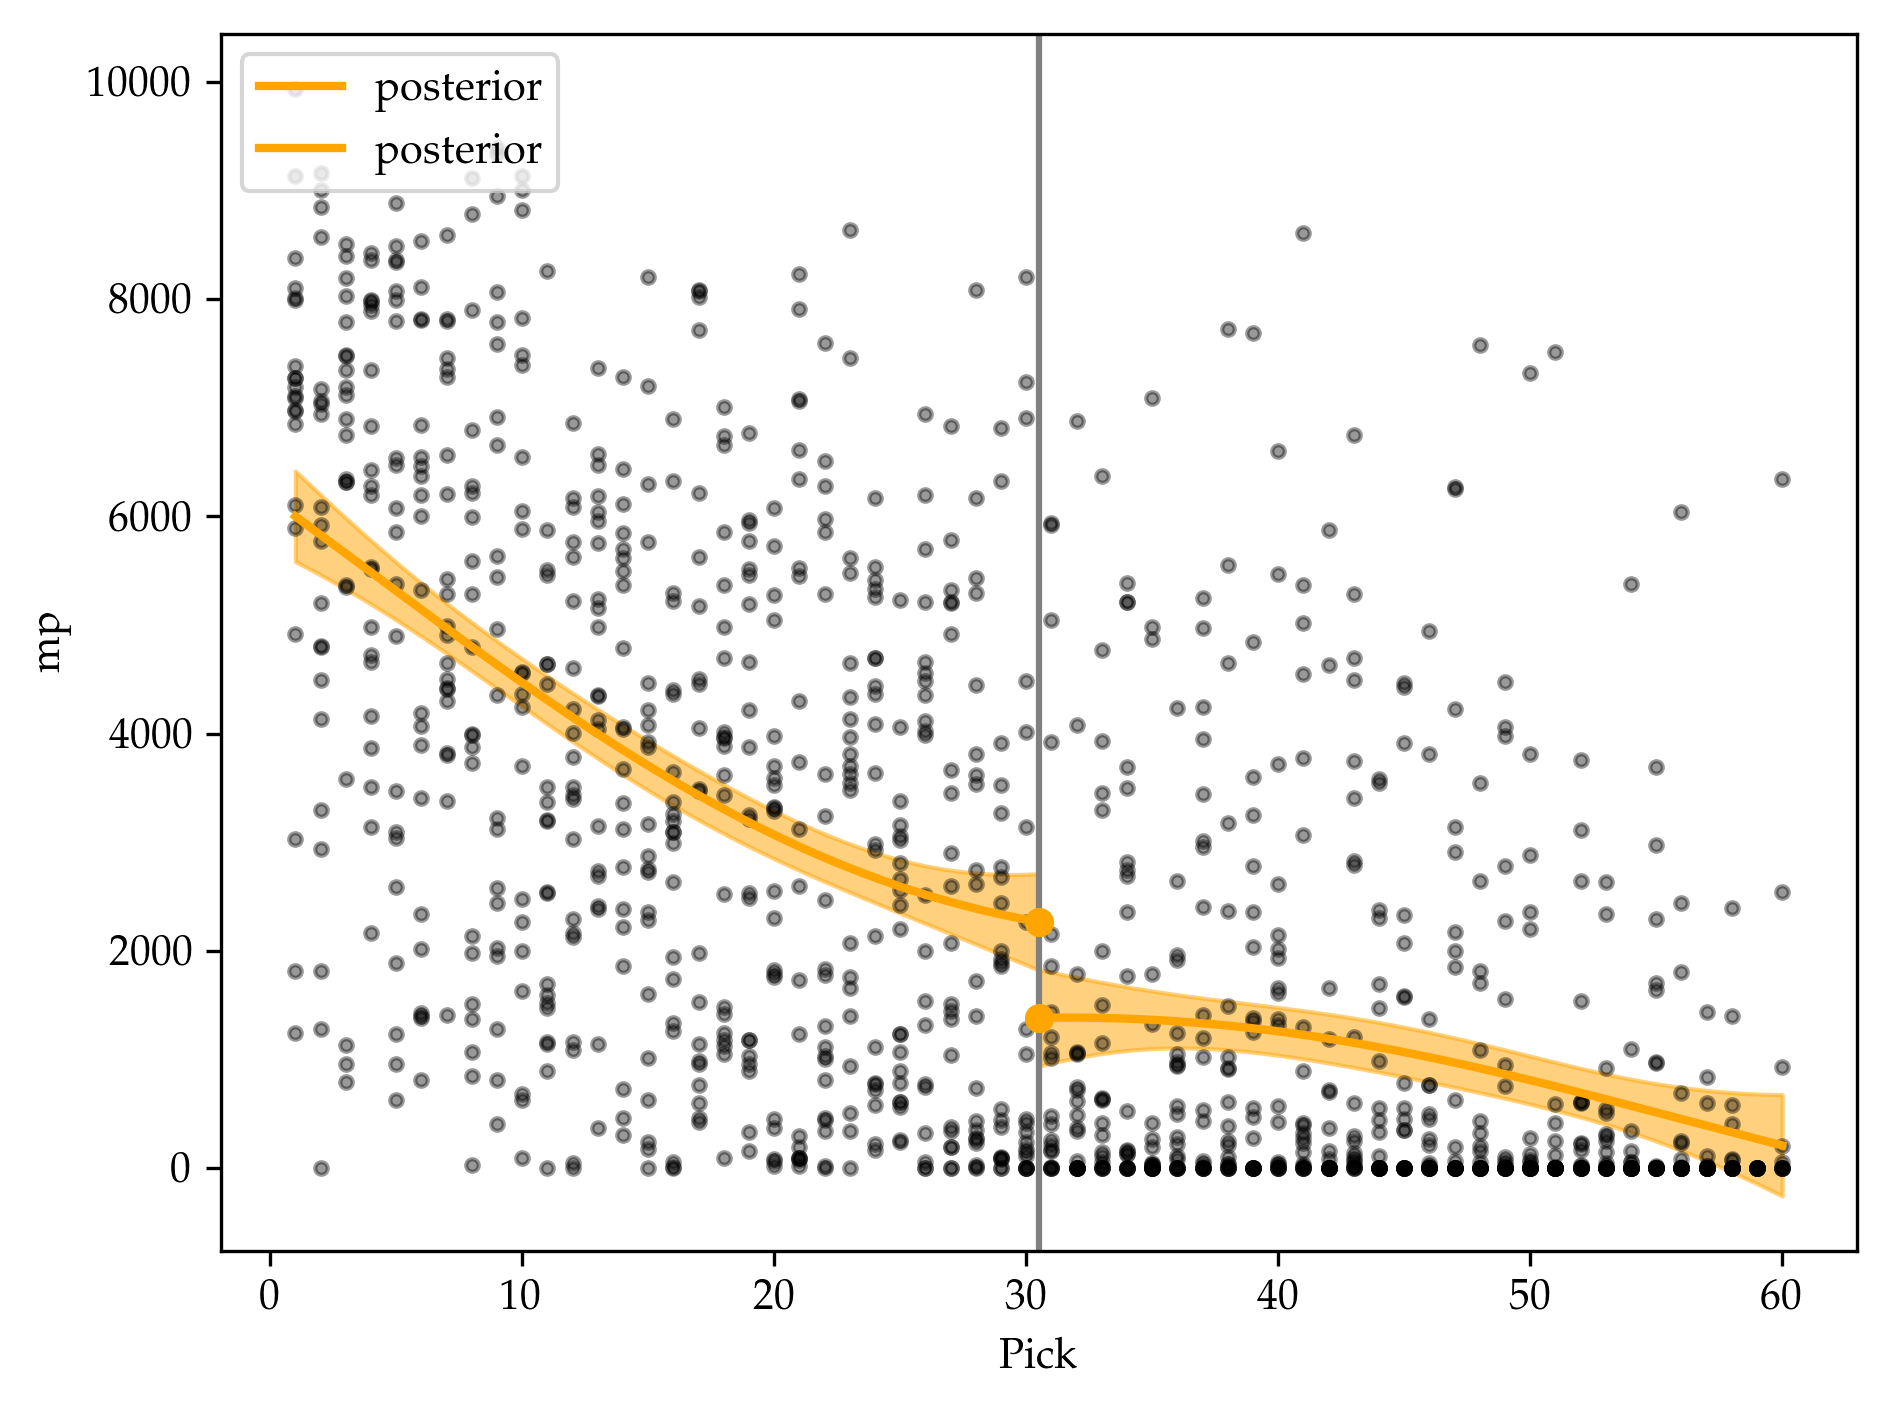

In [14]:
plot_2gp(both_gps, 30.5)
plt.xlabel("Pick")
plt.ylabel("mp")
plt.savefig("../figures/basketball_mp.png")

In [15]:
csv_fname(root::String) = joinpath("..", "basketball", "basketball_out", root * ".csv")

csv_fname (generic function with 1 method)

In [16]:
fig_fname(root::String) = joinpath("..", "basketball", "basketball_figures", root * ".png")

fig_fname (generic function with 1 method)

In [17]:
τpost, df_left, df_right = predict_gp(both_gps, 30.5)
df_both = vcat(df_left, df_right)
CSV.write(csv_fname("pick.mp"), df_both)
;

best_x: [2.06008, 3.00201, 1.54495]
#calls of objective function: 18
MLE for pick.bpm: ℓ=20.125867, σ_GP=4.687759, σ_ϵ=7.846618
posterior τ for pick.bpm: Normal(μ=2.864734, σ=1.212602)
best_x: [4.24079, 3.52504, 4.26783]
#calls of objective function: 19
MLE for pick.g: ℓ=33.955104, σ_GP=71.366250, σ_ϵ=69.462868
posterior τ for pick.g: Normal(μ=33.507384, σ=9.969907)
best_x: [7.60803, 3.40684, 7.90468]
#calls of objective function: 21
MLE for pick.mp: ℓ=30.169747, σ_GP=2709.948353, σ_ϵ=2014.297511
posterior τ for pick.mp: Normal(μ=883.853660, σ=314.195507)
best_x: [1.77735, 2.53447, 1.44495]
#calls of objective function: 23
MLE for pick.ws: ℓ=12.609752, σ_GP=4.241627, σ_ϵ=5.914175
posterior τ for pick.ws: Normal(μ=1.722456, σ=1.125100)
best_x: [0.375731, 2.2546, 0.505516]
#calls of objective function: 22
MLE for pickMeans.bpm: ℓ=9.531525, σ_GP=1.657841, σ_ϵ=1.456055
posterior τ for pickMeans.bpm: Normal(μ=2.121158, σ=1.099611)
best_x: [2.6777, 3.39679, 4.09276]
#calls of objective funct

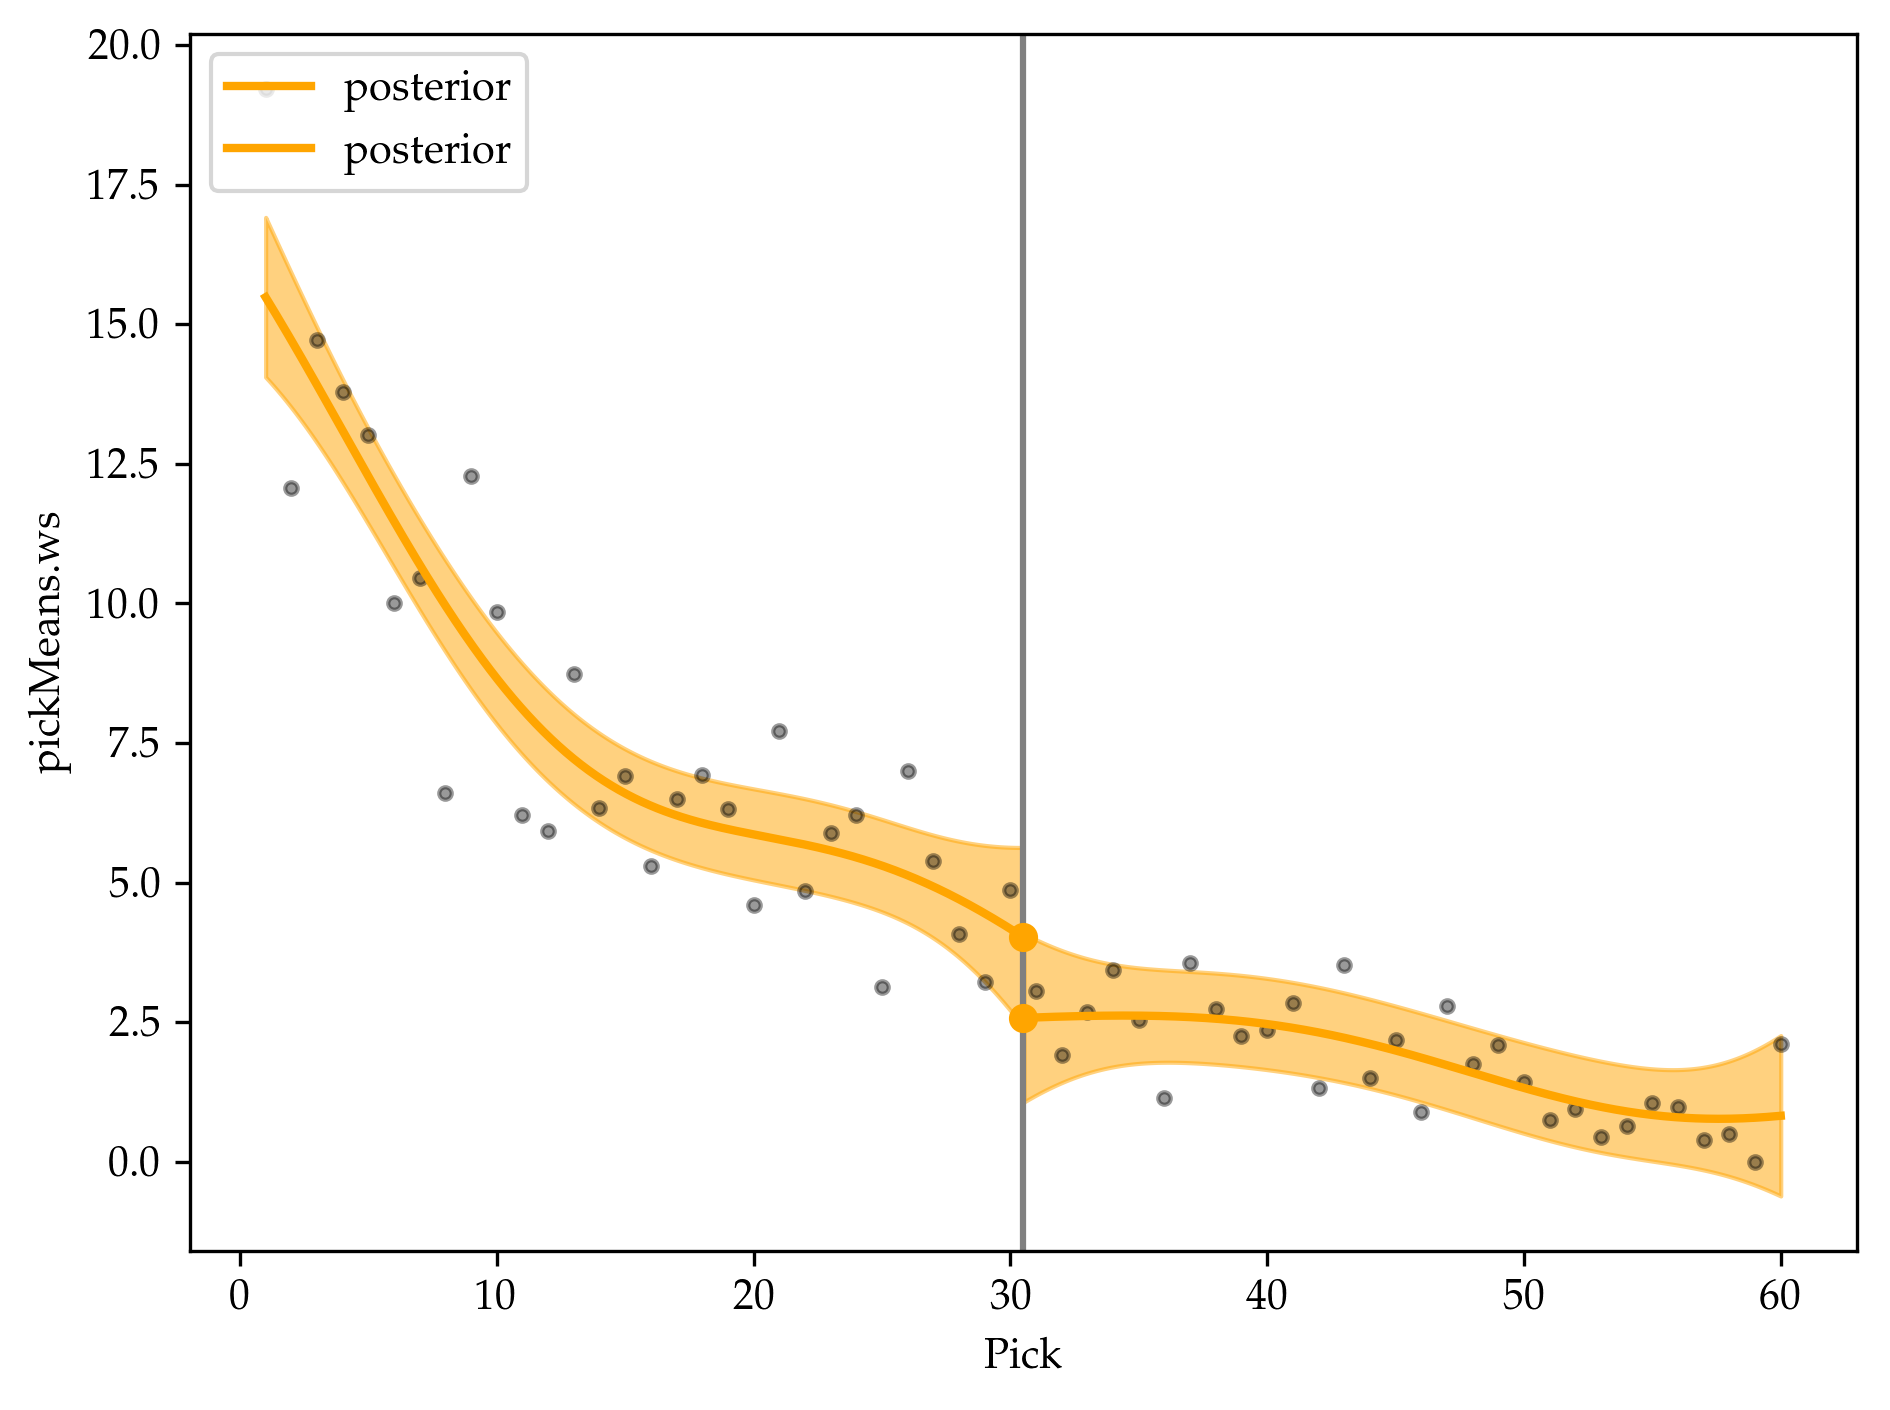

 19.565478 seconds (87.10 M allocations: 5.287 GiB, 7.67% gc time)


In [26]:
@time for root in ("pick.bpm", "pick.g", "pick.mp", 
             "pick.ws", "pickMeans.bpm", "pickMeans.g", 
             "pickMeans.mp", "pickMeans.ws")
    xy = load_fn(root)
    fit2gp = fit_2GP_meankern(xy[:x], xy[:y], 30.5)
    τpost, df_left, df_right = predict_gp(fit2gp, 30.5)
    k = fit2gp.k.kerns[1]
    @printf("MLE for %s: ℓ=%f, σ_GP=%f, σ_ϵ=%f\n", root, √k.ℓ2, √k.σ2, exp(fit2gp.logNoise))
    @printf("posterior τ for %s: Normal(μ=%f, σ=%f)\n", root, mean(τpost), std(τpost))
    df_both = vcat(df_left, df_right)
    CSV.write(csv_fname(root), df_both)
    plt.clf()
    plot_2gp(fit2gp, 30.5)
    plt.xlabel("Pick")
    plt.ylabel(root)
    plt.savefig(fig_fname(root))
end
;